<div style = 'text-align: center;'>
    <img src = '../images/ga_logo_large.png'>
</div>

# **Project 2: Ames Price Prediction Model**

---
### **Kaggle Submission**

This first submission is based on `Model 1`, which uses four numeric features to predict the final home sale price.<br>
The four features are in the same units (square feet) and they are: `lot_area`, `total_bsmt_sf`, `1st_flr_sf` and `2nd_flr_sf`.

---
### **Data Import & Cleaning**

In [502]:
# import needed libraries for this notebook

import numpy as np
import pandas as pd

# sklearn modules
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics

In [260]:
# read in test data for kaggle

file_path = '../datasets/test.csv'
ames_kaggle = pd.read_csv(file_path)

#check size
ames_kaggle.shape

(878, 80)

In [262]:
# check some rows
ames_kaggle.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


In [264]:
# check missing values and data types
ames_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               878 non-null    int64  
 1   PID              878 non-null    int64  
 2   MS SubClass      878 non-null    int64  
 3   MS Zoning        878 non-null    object 
 4   Lot Frontage     718 non-null    float64
 5   Lot Area         878 non-null    int64  
 6   Street           878 non-null    object 
 7   Alley            58 non-null     object 
 8   Lot Shape        878 non-null    object 
 9   Land Contour     878 non-null    object 
 10  Utilities        878 non-null    object 
 11  Lot Config       878 non-null    object 
 12  Land Slope       878 non-null    object 
 13  Neighborhood     878 non-null    object 
 14  Condition 1      878 non-null    object 
 15  Condition 2      878 non-null    object 
 16  Bldg Type        878 non-null    object 
 17  House Style     

The dataset will have to be cleaned and some columns properly formatted to the right data type.<br>
The cleanup workflow for this notebook will follow exactly the cleanup that was executed on the main dataset.  What this means is that all missing values will be filled with the values that were already selected for the main dataset, so the exploratory part is not needed, and thus will be skipped. 

---
**Column Names**<br>
First, convert all column names to snake case.  Use function below to aid in this task.

In [274]:
def fix_col_names(col_list):
    '''
    This function takes as argument a list of column names from a data frame.
    It returns a dictionary where each key is the current column name and the 
    corresponding value is the very same column name in snake case.
    
    Parameters:
    col_list: list of strings to pass in, these are the dataframe's column names.
    
    Return:
    dictionary: organized dictionary with all new column names to pass into data 
    frame and facilitate column conversion.
    '''
    columns_dict = {}
    
    for col in col_list:
        value = col.lower().replace(' ','_')
        columns_dict[col] = value
    
    return columns_dict

In [276]:
# get column names
cols = fix_col_names(ames_kaggle.columns.tolist())

In [278]:
# change column names
ames_kaggle.rename(columns = cols, inplace = True)

In [280]:
# confirm
ames_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               878 non-null    int64  
 1   pid              878 non-null    int64  
 2   ms_subclass      878 non-null    int64  
 3   ms_zoning        878 non-null    object 
 4   lot_frontage     718 non-null    float64
 5   lot_area         878 non-null    int64  
 6   street           878 non-null    object 
 7   alley            58 non-null     object 
 8   lot_shape        878 non-null    object 
 9   land_contour     878 non-null    object 
 10  utilities        878 non-null    object 
 11  lot_config       878 non-null    object 
 12  land_slope       878 non-null    object 
 13  neighborhood     878 non-null    object 
 14  condition_1      878 non-null    object 
 15  condition_2      878 non-null    object 
 16  bldg_type        878 non-null    object 
 17  house_style     

---
**Missing Values**<br>
Column: `lot_frontage`<br>
Fill in all `NaN` with the mean calculated for this column on the main dataset, which is 69.06.

In [282]:
# replace NaNs with mean value (69.06)
indexes = ames_kaggle[ames_kaggle['lot_frontage'].isnull()].index.tolist()
ames_kaggle.loc[indexes, 'lot_frontage'] = 69.06

---
Column: `alley`<br>
Fill all `NaN` values with `No_Alley`.

In [285]:
# make the change
indexes = ames_kaggle[ames_kaggle['alley'].isnull()].index.tolist()
ames_kaggle.loc[indexes, 'alley'] = 'No_Alley'

---
Column: `mas_vnr_type`<br>
Fill in all `NaN` to `NoMsn`

In [288]:
# make the change
indexes = ames_kaggle[ames_kaggle['mas_vnr_type'].isnull()].index.tolist()
ames_kaggle.loc[indexes, 'mas_vnr_type'] = 'NoMsn'

---
Column: `mas_vnr_area`<br>
Fill in all `NaN` to `0.0`

In [291]:
# change all missing values on 'mas_vnr_area' to 0
indexes = ames_kaggle[ames_kaggle['mas_vnr_area'].isnull()].index.tolist()
ames_kaggle.loc[indexes, 'mas_vnr_area'] = 0.0

---
Column: `bsmt_qual`<br>
Change all `NaN` values to `Nb`.

In [294]:
# make the change
indexes = ames_kaggle[ames_kaggle['bsmt_qual'].isnull()].index.tolist()
ames_kaggle.loc[indexes, 'bsmt_qual'] = 'Nb'

---
Column: `bsmt_cond` <br>
Change all `NaN` values to `Nb`.

In [297]:
# make the change
indexes = ames_kaggle[ames_kaggle['bsmt_cond'].isnull()].index.tolist()
ames_kaggle.loc[indexes, 'bsmt_cond'] = 'Nb'

---
Column: `bsmt_exposure` <br>
Change all `NaN` values to `Nb`.

In [300]:
# make the change
indexes = ames_kaggle[ames_kaggle['bsmt_exposure'].isnull()].index.tolist()
ames_kaggle.loc[indexes, 'bsmt_exposure'] = 'Nb'

---
Column: `bsmtfin_type_1`<br>
Change all `NaN` values to `Nb`.

In [303]:
# make the change
indexes = ames_kaggle[ames_kaggle['bsmtfin_type_1'].isnull()].index.tolist()
ames_kaggle.loc[indexes, 'bsmtfin_type_1'] = 'Nb'

---
Column: `bsmtfin_type_2`<br>
Change all `NaN` values to `Nb`.

In [306]:
# make the change
indexes = ames_kaggle[ames_kaggle['bsmtfin_type_2'].isnull()].index.tolist()
ames_kaggle.loc[indexes, 'bsmtfin_type_2'] = 'Nb'

---
Column: `electrical`<br>
Change all `NaN` values to `SBrkr`.

In [337]:
# make the change
indexes = ames_kaggle[ames_kaggle['electrical'].isnull()].index.tolist()
ames_kaggle.loc[indexes, 'electrical'] = 'SBrkr'

---
Column: `fireplace_qu`<br>
Change all `NaN` values to `Nf`.

In [342]:
# make the change
indexes = ames_kaggle[ames_kaggle['fireplace_qu'].isnull()].index.tolist()
ames_kaggle.loc[indexes,'fireplace_qu'] = 'Nf'

---
Column: `garage_type`<br>
Change all `NaN` values to `Ng`

In [347]:
# make the changes
indexes = ames_kaggle[ames_kaggle['garage_type'].isnull()].index.tolist()
ames_kaggle.loc[indexes, 'garage_type'] = 'Ng'

---
Column: `garage_yr_blt`<br>
Change all `NaN` values to `9999`

In [357]:
# make changes
indexes = ames_kaggle[ames_kaggle['garage_yr_blt'].isnull()].index.tolist()
ames_kaggle.loc[indexes, 'garage_yr_blt'] = '9999'

---
Column: `garage_finish`<br>
Change all `NaN` values to `Ng`.

In [363]:
# make changes
indexes = ames_kaggle[ames_kaggle['garage_finish'].isnull()].index.tolist()
ames_kaggle.loc[indexes, 'garage_finish'] = 'Ng'

---
Column: `garage_qual`<br>
Change all `NaN` values to `Ng`

In [370]:
# make the changes
indexes = ames_kaggle[ames_kaggle['garage_qual'].isnull()].index.tolist()
ames_kaggle.loc[indexes,'garage_qual'] = 'Ng'

---
Column: `garage_cond`<br>
Change all `NaN` values to `Ng`

In [373]:
# make the changes
indexes = ames_kaggle[ames_kaggle['garage_cond'].isnull()].index.tolist()
ames_kaggle.loc[indexes,'garage_cond'] = 'Ng'

---
Column: `pool_qc`<br>
Change all `NaN` values to `Np`.

In [381]:
# make the changes
indexes = ames_kaggle[ames_kaggle['pool_qc'].isnull()].index.tolist()
ames_kaggle.loc[indexes, 'pool_qc'] = 'Np'

---
Column: `fence`<br>
Change all `NaN` values to `NoFe`

In [385]:
# make the changes
indexes = ames_kaggle[ames_kaggle['fence'].isnull()].index.tolist()
ames_kaggle.loc[indexes, 'fence'] = 'NoFe'

---
Column: `misc_feature`<br>
Change all `NaN` values to `NoFea`.

In [389]:
# make the changes
indexes = ames_kaggle[ames_kaggle['misc_feature'].isnull()].index.tolist()
ames_kaggle.loc[indexes, 'misc_feature'] = 'NoFea'

All rows successfully cleaned.

---
**Data Types**<br>
Make sure every column's data type is consistent with the kind of data it holds.<br>
Use dictionary from `01_Intro_and_Cleaning` notebook.

In [413]:
# data type dictionary

dtypes_dict = {'id': 'O',
 'pid': 'O',
 'ms_subclass': 'int64',
 'ms_zoning': 'O',
 'lot_frontage': 'float64',
 'lot_area': 'int64',
 'street': 'O',
 'alley': 'O',
 'lot_shape': 'O',
 'land_contour': 'O',
 'utilities': 'O',
 'lot_config': 'O',
 'land_slope': 'O',
 'neighborhood': 'O',
 'condition_1': 'O',
 'condition_2': 'O',
 'bldg_type': 'O',
 'house_style': 'O',
 'overall_qual': 'int64',
 'overall_cond': 'int64',
 'year_built': 'int64',
 'year_remod/add': 'int64',
 'roof_style': 'O',
 'roof_matl': 'O',
 'exterior_1st': 'O',
 'exterior_2nd': 'O',
 'mas_vnr_type': 'O',
 'mas_vnr_area': 'float64',
 'exter_qual': 'O',
 'exter_cond': 'O',
 'foundation': 'O',
 'bsmt_qual': 'O',
 'bsmt_cond': 'O',
 'bsmt_exposure': 'O',
 'bsmtfin_type_1': 'O',
 'bsmtfin_sf_1': 'float64',
 'bsmtfin_type_2': 'O',
 'bsmtfin_sf_2': 'float64',
 'bsmt_unf_sf': 'float64',
 'total_bsmt_sf': 'float64',
 'heating': 'O',
 'heating_qc': 'O',
 'central_air': 'O',
 'electrical': 'O',
 '1st_flr_sf': 'int64',
 '2nd_flr_sf': 'int64',
 'low_qual_fin_sf': 'int64',
 'gr_liv_area': 'int64',
 'bsmt_full_bath': 'int64',
 'bsmt_half_bath': 'int64',
 'full_bath': 'int64',
 'half_bath': 'int64',
 'bedroom_abvgr': 'int64',
 'kitchen_abvgr': 'int64',
 'kitchen_qual': 'O',
 'totrms_abvgrd': 'int64',
 'functional': 'O',
 'fireplaces': 'int64',
 'fireplace_qu': 'O',
 'garage_type': 'O',
 'garage_yr_blt': 'int64',
 'garage_finish': 'O',
 'garage_cars': 'int64',
 'garage_area': 'float64',
 'garage_qual': 'O',
 'garage_cond': 'O',
 'paved_drive': 'O',
 'wood_deck_sf': 'float64',
 'open_porch_sf': 'float64',
 'enclosed_porch': 'float64',
 '3ssn_porch': 'float64',
 'screen_porch': 'float64',
 'pool_area': 'float64',
 'pool_qc': 'O',
 'fence': 'O',
 'misc_feature': 'O',
 'misc_val': 'float64',
 'mo_sold': 'int64',
 'yr_sold': 'int64',
 'sale_type': 'O'}

In [415]:
# cast all columns to correct data type
ames_kaggle = ames_kaggle.astype(dtypes_dict)

All columns should be cast to correct data type.  There are no missing values.  Data cleanup is complete.<br>
Save clean dataset.

In [425]:
# set up relative path
output_path = '../datasets/clean_data/kaggle_clean.csv'

In [428]:
# save to folder
ames_kaggle.to_csv(output_path, index = False)

Cleaned file successfully saved.

---

### **Model Preprocessing and Fitting**
**Model 1**

In [458]:
# import data for model

file_path = '../datasets/clean_data/ames_clean.csv'
ames = pd.read_csv(file_path)

In [462]:
# confirm dimensions and a few rows
print(ames.shape)
ames.head()

(2051, 81)


,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,69.06,13517,Pave,No_Alley,IR1,Lvl,...,0.0,0.0,Np,NoFe,NoFea,0.0,3,2010,WD,130500.0
1,544,531379050,60,RL,43.00,11492,Pave,No_Alley,IR1,Lvl,...,0.0,0.0,Np,NoFe,NoFea,0.0,4,2009,WD,220000.0
2,153,535304180,20,RL,68.00,7922,Pave,No_Alley,Reg,Lvl,...,0.0,0.0,Np,NoFe,NoFea,0.0,1,2010,WD,109000.0
3,318,916386060,60,RL,73.00,9802,Pave,No_Alley,Reg,Lvl,...,0.0,0.0,Np,NoFe,NoFea,0.0,4,2010,WD,174000.0
4,255,906425045,50,RL,82.00,14235,Pave,No_Alley,IR1,Lvl,...,0.0,0.0,Np,NoFe,NoFea,0.0,3,2010,WD,138500.0


In [472]:
# there should be no nulls
ames.isnull().sum().value_counts()

0    81
Name: count, dtype: int64

---
### **Create Features Matrix and Target Vector**

**Predictive Matrix**

In [476]:
features = ['1st_flr_sf', 'lot_area', '2nd_flr_sf', 'total_bsmt_sf']
X = ames[features]

X.shape

(2051, 4)

**Target Vector**
___________

In [479]:
y = ames['saleprice']

**Split Train and Test Data**
___________

In [482]:
# use 80/20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

In [484]:
# confirm split/shape
X_train.shape, X_test.shape

((1640, 4), (411, 4))

**Instantiate and Fit Linear Regression Model**
__________

In [487]:
# instance
model = LinearRegression()

In [489]:
# fit model
model.fit(X_train, y_train)

LinearRegression()

**Model Evaluation**
________

In [493]:
# train set R2 score
model.score(X_train, y_train)

0.6003525158990597

In [495]:
# test set R2 score
model.score(X_test, y_test)

0.6806383363380533

**Cross Validation**
______________

In [498]:
# keep 5-fold default
cross_val_score(model, X_train, y_train)

array([0.4044376 , 0.63722672, 0.526675  , 0.68572346, 0.65165071])

In [500]:
# average
cross_val_score(model, X_train, y_train).mean()

0.581142698116911

**Predictions and Evaluation**
_______________

In [518]:
# run predictions

predictions = model.predict(X_test)

In [520]:
# check first 10
predictions[:10]

array([258906.86908679, 181354.59517062, 165008.44749128, 126305.66124883,
       196576.55895341, 122671.63895015, 214512.15819954, 198651.92821075,
        58290.89706504, 156950.06535651])

In [534]:
# check root mean squared error
rmse = round(metrics.root_mean_squared_error(y_test, predictions), 2)
rmse

42976.92

### **Use Model on Kaggle Data**
_______

**Predictive Matrix**
_________

In [542]:
features = ['1st_flr_sf', 'lot_area', '2nd_flr_sf', 'total_bsmt_sf']
X_kaggle = ames_kaggle[features]

X_kaggle.shape

(878, 4)

**Kaggle Predictions**
_________

In [545]:
kaggle_preds = model.predict(X_kaggle)

In [551]:
# check first 10
kaggle_preds[:10]

array([214309.91850651, 280391.98729112, 154208.47508327, 131045.63050339,
       194714.00045558, 113804.55011249, 135730.0647303 , 175879.91606771,
       182285.42025921, 172305.79784739])

**Review Kaggle Predictions and Build Submission File**
_________

In [607]:
# convert to DF

ulloa_kaggle_model1 =pd.DataFrame({
    'Id': ames_kaggle['id'],
    'SalePrice': kaggle_preds
})

# check dimension
ulloa_kaggle_model1.shape

(878, 2)

In [609]:
# check first 10 rows
ulloa_kaggle_model1.head(10)

,Id,SalePrice
0,2658,214309.918507
1,2718,280391.987291
2,2414,154208.475083
3,1989,131045.630503
4,625,194714.000456
5,333,113804.550112
6,1327,135730.064730
7,858,175879.916068
8,95,182285.420259
9,1568,172305.797847


In [611]:
# check last 10 rows
ulloa_kaggle_model1.tail(10)

,Id,SalePrice
868,337,269794.337207
869,2765,224529.484253
870,1746,214877.271519
871,368,292130.615505
872,2806,194139.461379
873,1662,214690.179146
874,1234,225058.720662
875,1373,151195.604325
876,1672,115477.577524
877,1939,124494.664410


In [620]:
# check summary stats
ulloa_kaggle_model1.describe()

,SalePrice
count,878.000000
mean,179721.711355
std,58671.304069
min,47197.874649
25%,136895.410500
50%,171314.911384
75%,214533.646495
max,518240.913545


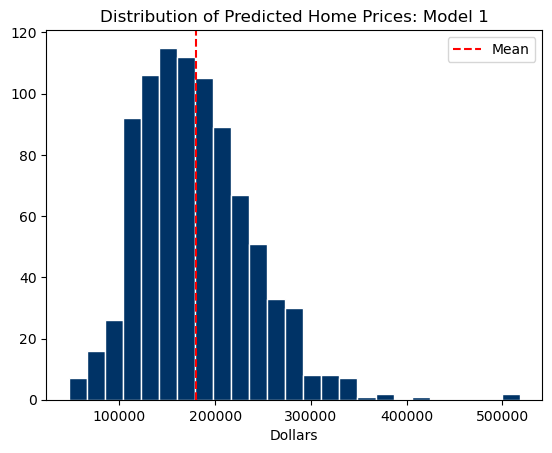

In [631]:
# check distribution

import matplotlib.pyplot as plt

plt.hist(ulloa_kaggle_model1['SalePrice'], bins = 25,color = '#003366', edgecolor = '#ffffff')
plt.axvline(x = 179721.711355, color = '#ff0000', linestyle = '--', label = 'Mean')
plt.title('Distribution of Predicted Home Prices: Model 1')
plt.xlabel('Dollars')
plt.legend()
plt.savefig('../images/model_01_hist.png')

In [641]:
# save kaggle predictions file

output_path = '../datasets/clean_data/ulloa_kaggle_1.csv'
ulloa_kaggle_model1.to_csv(output_path, index = False)